# Optimization

Hello, and welcome to our tutorial on optimization. Here, we will explore the four different optimizers which already have `Tequila` interfaces: a native GD optimizer, alongside interfaces for `SciPy`, `GPyOpt`, and `Phoenics`.

In [17]:
### start at the start: import statements!
import tequila as tq
import numpy as np

## Overview

**How to optimize an `Objective`:**

 In `tequila`, optimizers are accessed in several ways. They may be instantiated as objects directly, which can then be called; they are also accessible through `tq.minimize`. Either of these methods have an obligatory argument: an `Objective`. `tq.minimize` also requires you supply a `method`, which must be a string; the call methods of the GD, `SciPy`, and `GPyOpt` optimizers accept this key as well.
 
As keywords to any optimization call, you can pass down the usual compilation kwargs for quantum simulation in `Tequila`:
* `backend`, a string indicating which quantum simulator to use
* `samples`, an int indicating how many shots of the circuit to measure (None means full wf simulation)
* `device`, (generally) a string indicating which (real or emulated) quantum computer to sample from (requires samples be specified),
* `noise`, the NoiseModel object to apply to the circuits simulated (see the tutorial on noise). 

additional keywords you might use include:
* `variables`,  a `list` of the `Variable`s you want to optimize.
* `initial_values`, which gives a start point to optimization. If you supply arguments to `variables`, you also need to supply arguments to `initial_values` so that all non-optimized parameters have a value to use. 

Some of the optimizers take more, or different, keywords from the others, so check the documentation for each one. 
In case the optimizer has some degree of verbosity (currently, they all do), you can deactivate this with `silent=True`. 

The following optimization methods are available on your system in `Tequila`:

In [18]:
tq.optimizers.show_available_optimizers()

available methods for optimizer modules found on your system:
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
Supported optimizer modules:  ['scipy', 'phoenics', 'gpyopt', 'gd']
Installed optimizer modules:  ['scipy', 'gd']


We will use two different `Objective`s for optimization in this tutorial. The first of these is a two qubit expectation value with the tractable but non trivial hamiltonian $[Y(0)+Qm(0)]\otimes X(1)$, where $Qm=\frac{1}{2} (I + Z)$, the projector onto the 0 state. 

In [19]:
### optimizing the circuit in terms of pi makes the result of the optimization easier to interpret.

a = tq.Variable(name="a")*tq.numpy.pi
b = tq.Variable(name="b")*tq.numpy.pi
c = tq.Variable(name="c")*tq.numpy.pi
d = tq.Variable(name='d')*tq.numpy.pi

U1 = tq.gates.H(target=[0])
U1 += tq.gates.H(target=1)
U1 += tq.gates.Ry(target=0, angle=a)
U1 += tq.gates.Rz(target=1, angle=b)
U1 += tq.gates.Z(target=1,control=0)
U1 += tq.gates.Rx(target=0, angle=c)
U1 += tq.gates.Rx(target=1,angle=d)
U1 += tq.gates.Z(target=1,control=0)


### once we have a circuit, we pick a hamiltonian to optimize over
H1=(tq.paulis.Y(0)+tq.paulis.Qm(0))*tq.paulis.X(1)
O1=tq.ExpectationValue(U=U1,H=H1)

### we use the .draw function to pretty-print circuits via backend printers.
print('circuit 1, with 2 qubits, is as follows:')
tq.draw(U1,backend='qiskit')
print('We will optimize this circuit with respect to the Hamiltonian:', H1)

circuit 1, with 2 qubits, is as follows:
     ┌───┐┌───────────────┐   ┌───────────────┐   
q_0: ┤ H ├┤ RY(f((a,))_0) ├─■─┤ RX(f((c,))_2) ├─■─
     ├───┤├───────────────┤ │ ├───────────────┤ │ 
q_1: ┤ H ├┤ RZ(f((b,))_1) ├─■─┤ RX(f((d,))_3) ├─■─
     └───┘└───────────────┘   └───────────────┘   
c_0: ═════════════════════════════════════════════
                                                  
c_1: ═════════════════════════════════════════════
                                                  
We will optimize this circuit with respect to the Hamiltonian: +1.0000Y(0)X(1)+0.5000X(1)-0.5000Z(0)X(1)


Our second `Objective`, O2, will measure a 3-qubit circuit with respect to the Hamiltonian $Y(0)\otimes X(1) \otimes Y(2)$

In [20]:
### this time, don't scale by pi

H2 = tq.paulis.Y(0)*tq.paulis.X(1)*tq.paulis.Y(2)
U2 = tq.gates.Ry(tq.numpy.pi/2,0) +tq.gates.Ry(tq.numpy.pi/3,1)+tq.gates.Ry(tq.numpy.pi/4,2)
U2 += tq.gates.Rz('a',0)+tq.gates.Rz('b',1)
U2 += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
U2 += tq.gates.Ry('c',1) +tq.gates.Rx('d',2)
U2 += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
O2 = tq.ExpectationValue(H=H2, U=U2)

print('We will optimize the following circuit: \n')
tq.draw(U2)
print('\n With respect to the Hamiltonian:',H2)

We will optimize the following circuit: 

0: ───Ry(0.5π)─────Rz(0.318309886183791*pi*f((a,))_0)───@────────────────────────────────────────────@───────
                                                        │                                            │
1: ───Ry(0.333π)───Rz(0.318309886183791*pi*f((b,))_1)───X───@───Ry(0.318309886183791*pi*f((c,))_2)───X───@───
                                                            │                                            │
2: ───Ry(0.25π)─────────────────────────────────────────────X───Rx(0.318309886183791*pi*f((d,))_3)───────X───

 With respect to the Hamiltonian: +1.0000Y(0)X(1)Y(2)


## Local Optimizers

We will begin this tutorial by focusing on local optimizers. By local optimization, we mean the any optimization schema where the suggested parameters at step t are always a transformation of the parameters suggested at step t-1. This includes a large number of the standard optimization techniques in use today, like gradient descent.     `Tequila` comes with two local optimizers: a native gradient descent optimizer, implementing a number of the most popular gradient descent algorithms used in classical machine learning, as well as a plugin for the `SciPy` package (which is installed alongside `Tequila`), which allows the use of a number of gradient-free, gradient-based, and hessian-based optimization methods.

### The GD Optimizer
we will start this tutorial by looking at the GD optimizer.


In [21]:
print('the following methods are available for Gradient Descent optimization:\n')
print(tq.optimizers.optimizer_gd.OptimizerGD.available_methods())

the following methods are available for Gradient Descent optimization:

['adam', 'adagrad', 'adamax', 'nadam', 'sgd', 'momentum', 'nesterov', 'rmsprop', 'rmsprop-nesterov']


As one sees, a variety of methods are available for optimization. Here, 'sgd' refers to the standard gradient descent algorithm, without momentum. like all tequila optimizers, the GD optimizer has a minimize function and most of the arguments are the same. However, there is one important difference: the GD optimizer takes a learning rate, lr. This parameter mediates step size in all of the GD optimizer methods; it is a positive float which scales the step in the direction of the gradient. 


We will now optimize O1, our two-qubit expectation value, choosing starting angles equivalent to $\frac{1}{4}\pi$ for all four variables, and optimizing via the ['Adam'](https://towardsdatascience.com/_adam-latest-trends-in-deep-learning-optimization-6be9a291375c) method.

In [24]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.1

### For even more fun, try using sampling with the samples keyword, 
### or pick your favorite backend with the 'backend' keyword!

adam_result=tq.minimize(objective=O1,lr=lr,
              method='adam',
              maxiter=80,
              initial_values=init,
              silent=True)

The plots below show the trajectory of both the value of the objective and the values of the angles as a function of time.

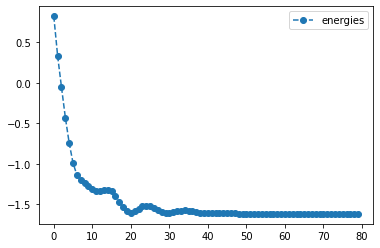

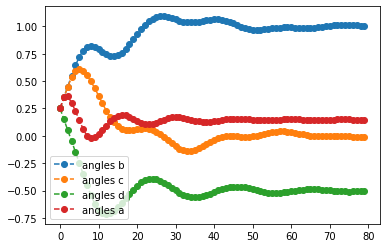

best energy:  -1.6179942172570136
optimal angles:  b : 1.0037044962376886
c : -0.0020942074899867142
d : -0.498209057390019
a : 0.14749682605178346



In [25]:
adam_result.history.plot('energies')
adam_result.history.plot('angles')
print('best energy: ',adam_result.energy)
print('optimal angles: ',adam_result.angles)

**We see that, minus a few hiccups, all the angles converge to optimimum values.**

**Let's repeat what we did above, but with a few of the other methods! Here's RMSprop:**

RMSprop optimization results:


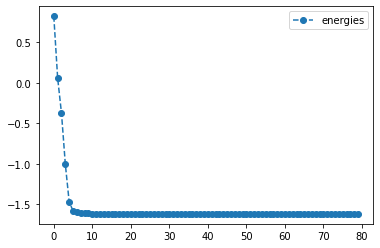

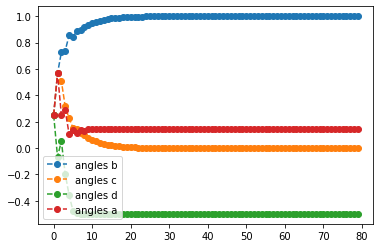

best energy:  -1.6180339887498905
optimal angles:  b : 1.0000000183809166
c : -1.625339216876925e-08
d : -0.5000000021961905
a : 0.14758363531643576



In [28]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.01
rms_result=tq.minimize(objective=O1,lr=lr,
              method='rmsprop',
              maxiter=80,
              initial_values=init,
              silent=True)
print('RMSprop optimization results:')
rms_result.history.plot('energies')
rms_result.history.plot('angles')
print('best energy: ',rms_result.energy)
print('optimal angles: ',rms_result.angles)

**... And here's Momentum:**

momentum optimization results:


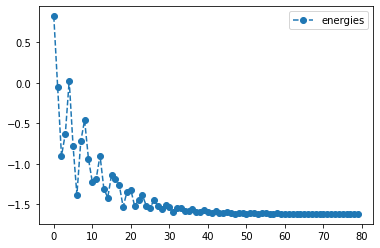

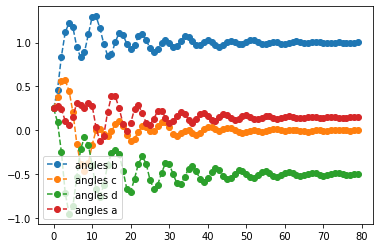

best energy:  -1.6178164176706864
optimal angles:  b : 0.9975386964199592
c : -0.0008949959645234715
d : -0.5018114831041253
a : 0.153130292696303



In [30]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.1
mom_result=tq.minimize(objective=O1,lr=lr,
              method='momentum',
              maxiter=80,
              initial_values=init,
              silent=True)

print('momentum optimization results:')
mom_result.history.plot('energies')
mom_result.history.plot('angles')
print('best energy: ',mom_result.energy)
print('optimal angles: ',mom_result.angles)

Note that when using the [RMSprop](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) method, we reduced the learning rate from 0.1 to 0.01. Different methods may be more or less sensitive to choices of initial learning rate. Try going back to the previous examples, and choosing different learning rates, or different initial parameters, to gain a feel for how sensitive different methods are.

**The GD optimizer, with the Quantum Natural Gradient:**

The Quantum Natural Gradient, or QNG, is a novel method of calculating gradients for quantum systems, inspired by the natural gradient sometimes employed in classical machine learning. The usual gradient we employ is with respect to a euclidean manifold, but this is not the only geometry -- nor even, the optimal geometry -- of quantum space. The QNG is, in essence, a method of taking gradients with respect to (an approximation to) the Fubini-Study metric. For information on how (and why) the QNG is used, see [Stokes et.al](https://arxiv.org/abs/1909.02108). 

Using the qng in Tequila is as simple as passing in the keyword gradient='qng' to optimizers which support it, such as the GD optimizer.  We will use it to optimize O2, our 3 qubit `Objective`, and then compare the results to optimizing the same circuit with the regular gradient.

In [ ]:
### the keyword stop_count, below, stops optimization if no improvement occurs after 50 epochs.
### let's use a random initial starting point:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}

lr=0.01
qng_result = tq.minimize(objective=O2,
                     gradient='qng',
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=init, silent=True)

In [ ]:
qng_result.history.plot('energies')
qng_result.history.plot('angles')
print('best energy with qng: ',qng_result.energy)
print('optimal angles with qng: ',qng_result.angles)

**To gain appreciation for why one might use the QNG, let's optimize the same circuit with the same learning rate and the same method, but without QNG.**

In [ ]:
lr=0.01
sgd_noqng_result = tq.minimize(objective=O2,
                     gradient=None,
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=init, silent=True)
print('plotting what happens without QNG')
sgd_noqng_result.history.plot('energies')
sgd_noqng_result.history.plot('angles')
print('best energy without qng: ',sgd_noqng_result.energy)
print('optimal angles without qng: ',sgd_noqng_result.angles)

Though the starting point was random you will most likely see that the QNG run achieved a greater degree of improvement -- it will not perform worse --, and that the trajectories followed by angles there were different from those followed by angles in the sgd-only optimization. Feel free to play around with other methods, learning rates, or circuits in the space below!


In [ ]:
### Use this space to optimize your own circuits!

### The SciPy Optimizer

`SciPy` is one of the most popular optimization packages in `Python`. It offers a wide variety of optimization strategies. We will not cover them here; for a full exploration of all the `SciPy` methods, see [their docs](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html). Here, we will exhibit a few of the more powerful options available.

In [ ]:
print('The following methods are available from SciPy:')
print(tq.optimizers.optimizer_scipy.available_methods())

We will try three different optimizers: `COBYLA`, which is gradient-free, `L-BFGS-B`, which employs gradients, and `NEWTON-CG`, which employs the Hessian.

In [15]:
print('As a reminder: we will optimize:')
try:
    tq.draw(U1,backend='qiskit')
except:
    tq.draw(U1)
print('With respect to the Hamiltonian: ', H1)

As a reminder: we will optimize:
     ┌───┐┌───────────────┐   ┌───────────────┐   
q_0: ┤ H ├┤ RY(f((a,))_0) ├─■─┤ RX(f((c,))_2) ├─■─
     ├───┤├───────────────┤ │ ├───────────────┤ │ 
q_1: ┤ H ├┤ RZ(f((b,))_1) ├─■─┤ RX(f((d,))_3) ├─■─
     └───┘└───────────────┘   └───────────────┘   
c_0: ═════════════════════════════════════════════
                                                  
c_1: ═════════════════════════════════════════════
                                                  
With respect to the Hamiltonian:  +1.0000Y(0)X(1)+0.5000X(1)-0.5000Z(0)X(1)


In [ ]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}

cobyla_result = tq.minimize(objective=O1,
                            method="cobyla", 
                            initial_values=init, 
                            tol=1.e-3, method_options={"gtol":1.e-3},
                            silent=True)

cobyla_result.history.plot('energies')
cobyla_result.history.plot('angles')
print('best energy with cobyla: ',cobyla_result.energy)
print('optimal angles with cobyla: ',cobyla_result.angles)

In [ ]:

lb_result = tq.minimize(objective=O1,
                            method="l-bfgs-b", 
                            initial_values=init, 
                            tol=1.e-3, method_options={"gtol":1.e-3},
                            silent=True)

lb_result.history.plot('energies')
lb_result.history.plot('angles')
print('best energy with L-BFGS-B: ',lb_result.energy)
print('optimal angles with L-BFGS-B: ',lb_result.angles)

In [ ]:
newton_result = tq.minimize(objective=O1,
                            method="newton-cg", 
                            initial_values=init, 
                            tol=1.e-3, method_options={"gtol":1.e-3},
                            silent=True)

newton_result.history.plot('energies')
newton_result.history.plot('angles')
print('best energy with NEWTON-CG: ',newton_result.energy)
print('optimal angles with NEWTON-CG: ',newton_result.angles)

All three of the methods converged to the same minimum, but not necessarily to the same angles; the gradient and hessian based methods converged to approximately the same angles in similar time. 

**Scipy Extras: numerical gradients and Hessians**
Scipy allows for the use of numerical gradients. To use them, pass down keywords to the `gradient` argument, like `'2-point'`. We will not display their use here, since they are a poor approximation to the gradient of the circuits  seen here.

**Scipy Extras: the QNG in SciPy**
Scipy is also configured to use the qng, just as the gd optimizer is. All one needs to do is set `gradient=qng`. Let's See how QNG interacts with the `BFGS` optimizer. We will use 02, our 3-qubit expectationvalue, that we used previously.

In [ ]:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}
bfgs_qng_result = tq.minimize(objective=O2,
                     gradient='qng',
                     method='bfgs', maxiter=200,lr=lr,
                     initial_values=init, silent=True)
print('plotting what happens with QNG')
bfgs_qng_result.history.plot('energies')
bfgs_qng_result.history.plot('angles')
print('best energy with qng: ',bfgs_qng_result.energy)
print('optimal angles with qng: ',bfgs_qng_result.angles)

In [ ]:
bfgs_noqng_result = tq.minimize(objective=O2,
                     gradient=None,
                     method='bfgs', maxiter=200,lr=lr,
                     initial_values=init, silent=True)
print('plotting what happens without QNG')
bfgs_noqng_result.history.plot('energies')
bfgs_noqng_result.history.plot('angles')
print('best energy without qng: ',bfgs_noqng_result.energy)
print('optimal angles without qng: ',bfgs_noqng_result.angles)

## Bayesian optimization


[Bayesian optimization](https://arxiv.org/abs/1807.02811) is a method of global optimization, often used to tune hyperparameters in classical learning. It has also seen use in the optimization of [quantum circuits](https://arxiv.org/pdf/1812.08862.pdf). Tequila currently supports 2 different bayesian optimization algorithms: [Phoenics](https://github.com/aspuru-guzik-group/phoenics) and [GPyOpt](https://github.com/SheffieldML/GPyOpt), optimizers originally developed for optimizing expensive experimental procedures in chemistry. Click the links to get to the respective github pages, and download the optimizers before continuing this tutorial.

### GPyOpt

GPyOpt can be used like any of our other optimizers. Like the GD and SciPy optimizers, it also takes a 'method' keyword. 3 methods are supported: `'lbfgs'`,`'DIRECT'`, and `'CMA'`. See the `GPyOpt` github for more info.

In [ ]:
print('As a reminder, we will optimize')
tq.draw(U,backend='qiskit')
print(O1)

In [ ]:
### let's use the lbfgs method.
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
### note: no lr is passed here! there are fewer tunable keywords for this optimizer.
result=tq.minimize(objective=O1,
              method='lbfgs',
              maxiter=80,
              initial_values=init)

print('GPyOpt optimization results:')
result.history.plot('energies')
result.history.plot('angles')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

**Don't worry, the plot's not broken!**
Perhaps you are looking at the plots above in horror. But, do take note: bayesian optimization is a global, exploratory optimization method, designed to explore large portions of parameter space while still seeking out optimality. Look at the optimal energy again, and one sees that the best performance of this optimization method matched that of all the gradient descent methods. We will apply gpyopt, next, to the QNG example circuit above, and see how bayesian optimization compares to QNG and SGD.

In [ ]:
print('Hey, remember me?')
tq.draw(U2)
### the keyword stop_count, below, stops optimization if no improvement occurs after 50 epochs.
### let's use a random initial starting point:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}

gpy_result = tq.minimize(objective=O2,maxiter=25,method='lbfgs',
                     initial_values=init)

gpy_result.history.plot('energies')
print('best energy: ',gpy_result.energy)
print('optimal angles: ',gpy_result.angles)

**In a very, very small number of steps, GPyOpt is able to match the performance of SGD with the QNG.**

**There's a few extras you can access if you are well-familiar with GPyOpt.** We return as part of `result` an attribute `result.object`, which is a native `GPyOpt` `BayesianOptimization` object -- the one built and run during your optimization. It has some plotting features you can use. 

In [ ]:
obj=gpy_result.object
obj.plot_convergence()

If your function has 1 or 2 parameters (but no more) you can also see a plot of its acquisition function! see [here](https://www.blopig.com/blog/2019/10/a-gentle-introduction-to-the-gpyopt-module/) for more info!

You can also extract the acquisition function of the model itself, and play with it (it takes ones object, an np array, as input), using:

`acq=result.object.acquisition.acquisition_function`

### Phoenics

Finally, we turn to `Phoenics`. This algorithm, originally developed within the Aspuru-Guzik group, can be accessed in the usual fashion. It's performance on the two-qubit optimization circuit is shown below. Note that the number of datapoints exceeds the provided __maxiter__; __maxiter__ here controls the number of parameter __batches__ suggested by phoenics. phoenics suggests a number of parameter sets to try out, per batch, that scales with the number of parameters (in a nonlinear fashion), so you may want to set maxiter lower if you are only playing around.

In [ ]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
print('With phoenics we will optimize:')
print(o1)
### to see what you can pass down to phoenics, see the tequila documentation for that module.
p_result=tq.minimize(objective=O1,
            method='Phoenics',
            maxiter=5,
            initial_values=init,
            silent=False)

print('Phoenics optimization results on 2 qubit circuit:')
p_result.history.plot('energies')
p_result.history.plot('angles')
print('best energy: ',p_result.energy)
print('optimal angles: ',p_result.angles)

We also have returned to you the phoenics object. One interesting object we can extract from this is the acquisition function. You can obtain this indirectly, using resut.object.bayesian_network.kernel_contribution. This function takes a numpy array  ( a point in your parameter space) and returns 2 numbers, x and y; the acquisition function then has the value x*y. Note: this is often zero.




In [ ]:
kc=p_result.object.bayesian_network.kernel_contribution
random_point=np.random.uniform(0,2*np.pi,4)
f,s=kc(random_point)
random_ac=f*s
print('random point ', random_point, ' has acquisition function value ',random_ac)

## This concludes our tutorial. Hope you had fun! Happy optimizing!